# ANALYSIS OF CONTROL DATASETS TO SEE REPEATABILITY AND REPRODUCIBILITY IN OUR RESULTS AND FINDINGS

In [1]:
# Libraries
import seaborn as sns
import numpy as np
from pathlib import Path
import sys
import pandas as pd

# Add /Source to sys.path if not already present
project_root = Path.cwd().parent
source_path = project_root / "src"

if source_path.exists() and str(source_path) not in sys.path:
    sys.path.insert(0, str(source_path))

# Utility functions
from calcium_activity_characterization.analysis.visualizers import (
    plot_violin,
    plot_points_mean_std,
    visualize_image,
    plot_scatter_size_coded,
    plot_histogram
    )
from calcium_activity_characterization.io.csv_loader import load_dataset
from calcium_activity_characterization.analysis.statistics import (
    analyze_peak_intervals
)

sns.set(style="whitegrid")

# Define paths to control datasets
path = "D:/Mateo/Results"

# Load and merge datasets
peaks = load_dataset(path=path, file_name="merged_peaks.csv")
cells = load_dataset(path=path, file_name="merged_cells.csv")
events = load_dataset(path=path, file_name="merged_events.csv")
communications = load_dataset(path=path, file_name="merged_communications.csv")
experiments = load_dataset(path=path, file_name="experiments.csv")

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")


## Define control datasets
> All image sequences that are first run, spontaneous and have more than 900 cells in the FoV.

In [2]:
cells_counts = cells.groupby("dataset")["Cell ID"].count()
experiments["Number of cells"] = experiments["dataset"].map(cells_counts)

control_experiments = experiments[(experiments["condition"] == "control - 1st run") &
                                  (experiments["Number of cells"] > 900)].copy()

display(control_experiments)

control_peaks = peaks[peaks["dataset"].isin(control_experiments["dataset"])].copy()
control_cells = cells[cells["dataset"].isin(control_experiments["dataset"])].copy()
control_events = events[events["dataset"].isin(control_experiments["dataset"])].copy()
control_communications = communications[communications["dataset"].isin(control_experiments["dataset"])].copy()

path      date image_sequence experiment_type  \
0    D:/Mateo/20250326/Output/IS1  20250326            IS1     spontaneous   
2    D:/Mateo/20250326/Output/IS3  20250326            IS3     spontaneous   
4    D:/Mateo/20250404/Output/IS1  20250404            IS1     spontaneous   
17  D:/Mateo/20250409/Output/IS09  20250409           IS09     spontaneous   
19  D:/Mateo/20250409/Output/IS11  20250409           IS11     spontaneous   

            condition  confluency concentration time  \
0   control - 1st run     1200000           NaN  NaN   
2   control - 1st run     1200000           NaN  NaN   
4   control - 1st run     1200000           NaN  NaN   
17  control - 1st run     1200000           NaN  NaN   
19  control - 1st run     1200000           NaN  NaN   

                                              dataset  Number of cells  
0   20250326__IS1__spontaneous__control - 1st run_...             1074  
2   20250326__IS3__spontaneous__control - 1st run_...              985  
4   20250404__IS1__spontaneous__control - 1st run_...             1234  
17  20250409__IS09__spontaneous__control - 1st run...             1325  
19  20250409__IS11__spontaneous__control - 1st run...             1011

## GLOBAL EVENTS ANALYSIS

[2025-08-11 16:06:20] [INFO] calcium: plot_violin: removed 56 outliers out of 27524 on 'Duration (s)' (lower=-104, upper=225)


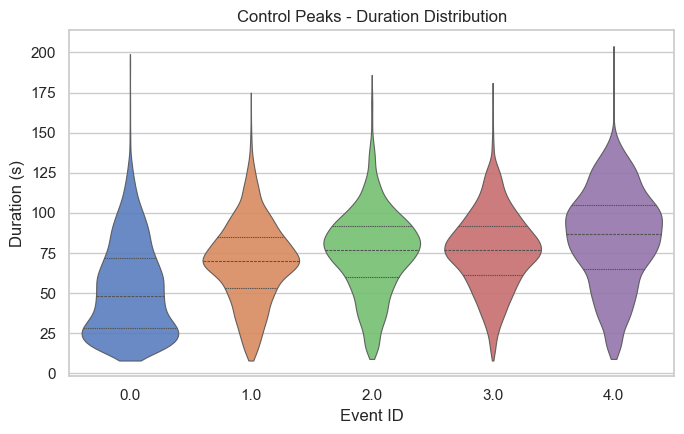

[2025-08-11 16:06:20] [INFO] calcium: plot_violin: removed 132 outliers out of 27524 on 'Prominence (noise std units)' (lower=-352.28, upper=714.7)


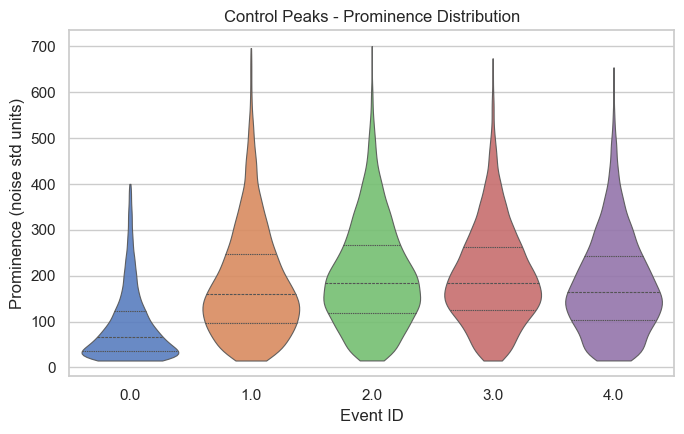

In [3]:
global_event_ids = control_events.loc[control_events["Event type"] == "GlobalEvent", "Event ID"]
subset_peaks_global_events = control_peaks[control_peaks["Event ID"].isin(global_event_ids)]

plot_violin(
    df=subset_peaks_global_events,
    x="Event ID",
    y="Duration (s)",
    title="Control Peaks - Duration Distribution",
    ylabel="Duration (s)",
    xlabel="Event ID",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    outliers_bygroup="Event ID",
    dodge=False
)
plot_violin(
    df=subset_peaks_global_events,
    x="Event ID",
    y="Prominence (noise std units)",
    title="Control Peaks - Prominence Distribution",
    ylabel="Prominence (noise std units)",
    xlabel="Event ID",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    outliers_bygroup="Event ID",
    dodge=False
)

[2025-08-11 16:12:04] [INFO] calcium: plot_points_mean_std: removed 0 outliers out of 23 on 'Time to 50% (s)' (lower=22, upper=99)


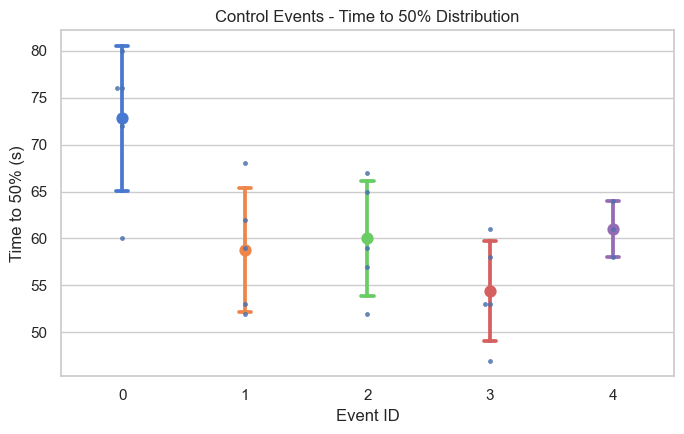

[2025-08-11 16:12:05] [INFO] calcium: plot_points_mean_std: removed 0 outliers out of 23 on 'Normalized peak rate at 50% (% of peaks/s)' (lower=-0.45, upper=4.45)


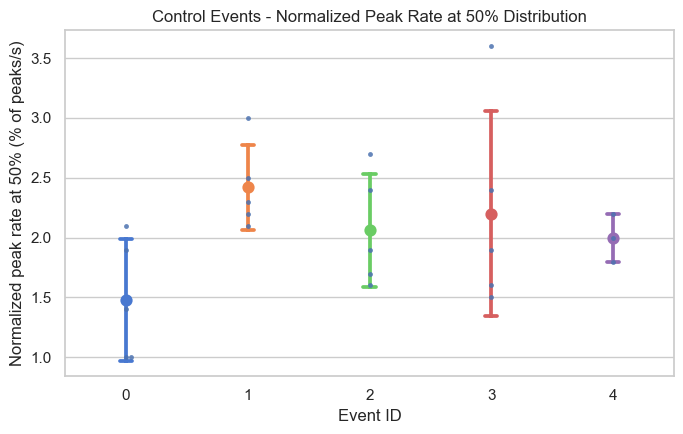

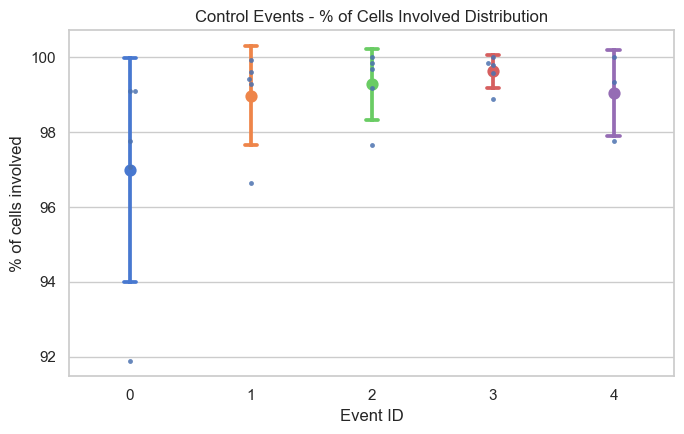

In [15]:
global_events = control_events[control_events["Event type"] == "GlobalEvent"].copy()

cell_counts = cells.groupby("dataset").size().rename("Total number of cells").reset_index()
global_events = global_events.merge(cell_counts, on="dataset", how="left")

global_events["% of cells involved"] = (100 * global_events["Number of cells involved"] / global_events["Total number of cells"]).round(2)

plot_points_mean_std(
    df=global_events,
    x="Event ID",
    y="Time to 50% (s)",
    title="Control Events - Time to 50% Distribution",
    ylabel="Time to 50% (s)",
    xlabel="Event ID",
    filter_outliers=True,
    outliers_bounds=(3, 3)
)
plot_points_mean_std(
    df=global_events,
    x="Event ID",
    y="Normalized peak rate at 50% (% of peaks/s)",
    title="Control Events - Normalized Peak Rate at 50% Distribution",
    ylabel="Normalized peak rate at 50% (% of peaks/s)",
    xlabel="Event ID",
    filter_outliers=True,
    outliers_bounds=(3, 3)
)
plot_points_mean_std(
    df=global_events,
    x="Event ID",
    y="% of cells involved",
    title="Control Events - % of Cells Involved Distribution",
    ylabel="% of cells involved",
    xlabel="Event ID",
    filter_outliers=False,
    outliers_bounds=(3, 3)
)

### Inter-peak intervals

dataset  periodicity  frequency
0  20250326__IS1__spontaneous__control - 1st run_...     0.911429   0.004149
1  20250326__IS3__spontaneous__control - 1st run_...     0.740251        NaN
2  20250404__IS1__spontaneous__control - 1st run_...     0.839482   0.003322
3  20250409__IS09__spontaneous__control - 1st run...     0.982643   0.002865
4  20250409__IS11__spontaneous__control - 1st run...     0.905170   0.003021

[2025-08-11 16:06:21] [INFO] calcium: plot_points_mean_std: removed 0 outliers out of 18 on 'interval' (lower=-57.25, upper=649.75)


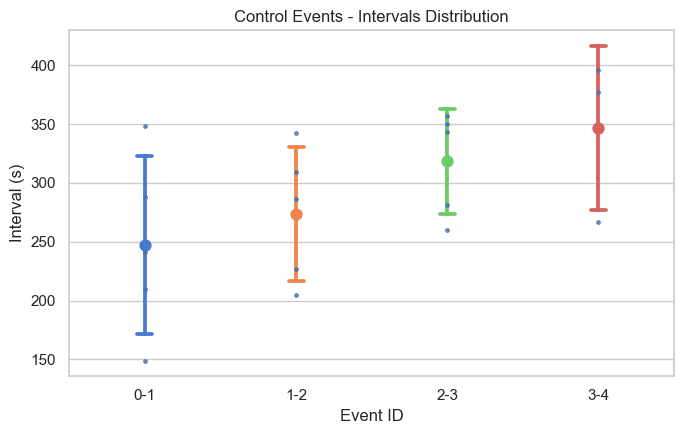

Periodicity 
 - N = 5
 - Mean = 0.88 a.u.
 - Std = 0.09 a.u.

Frequency 
 - N = 4
 - Mean = 0.0033 Hz
 - Std = 0.0006 Hz



In [5]:
intervals_list = []
periodicity_list = []

for dataset_name, df_subset in global_events.groupby("dataset"):
    intervals, periodicity, frequency = analyze_peak_intervals(df_subset["Event peak time (s)"].tolist())
    periodicity_list.append({
        "dataset": dataset_name,
        "periodicity": periodicity,
        "frequency": frequency if periodicity > 0.8 else None
    })
    for idx, val in enumerate(intervals):
        intervals_list.append({
            "dataset": dataset_name,
            "index": f"{idx}-{idx+1}",
            "interval": val
        })

intervals_df = pd.DataFrame(intervals_list)
periodicity_df = pd.DataFrame(periodicity_list)

display(periodicity_df)

plot_points_mean_std(
    df=intervals_df,
    x="index",
    y="interval",
    title="Control Events - Intervals Distribution",
    ylabel="Interval (s)",
    xlabel="Event ID",
    filter_outliers=True,
    outliers_bounds=(3, 3)
)

print(f"Periodicity \n - N = {periodicity_df['periodicity'].count()}\n - Mean = {periodicity_df['periodicity'].mean():.2f} a.u.\n - Std = {periodicity_df['periodicity'].std():.2f} a.u.\n")
print(f"Frequency \n - N = {periodicity_df['frequency'].count()}\n - Mean = {periodicity_df['frequency'].mean():.4f} Hz\n - Std = {periodicity_df['frequency'].std():.4f} Hz\n")


### Mapping of cell occurences in global events

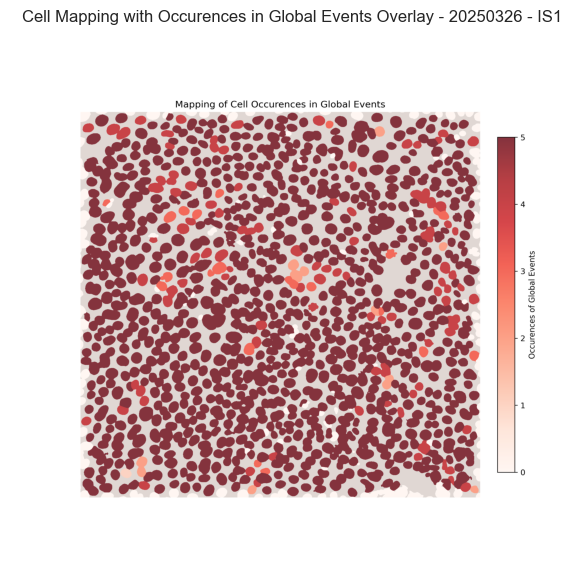

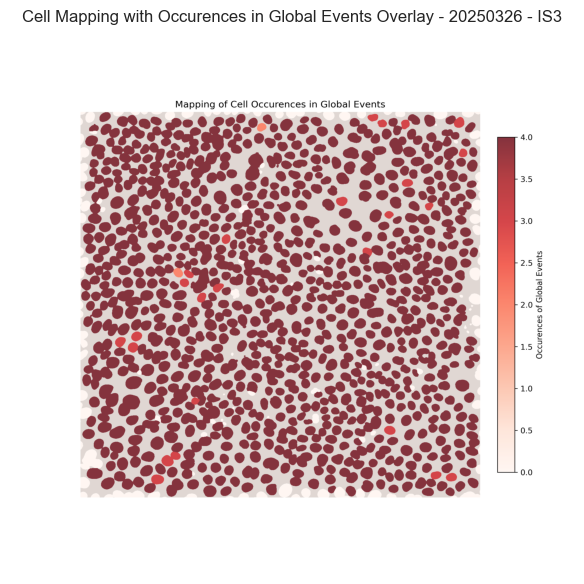

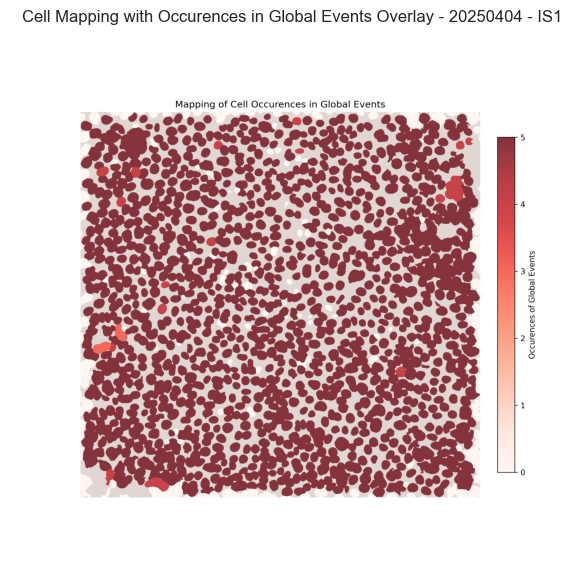

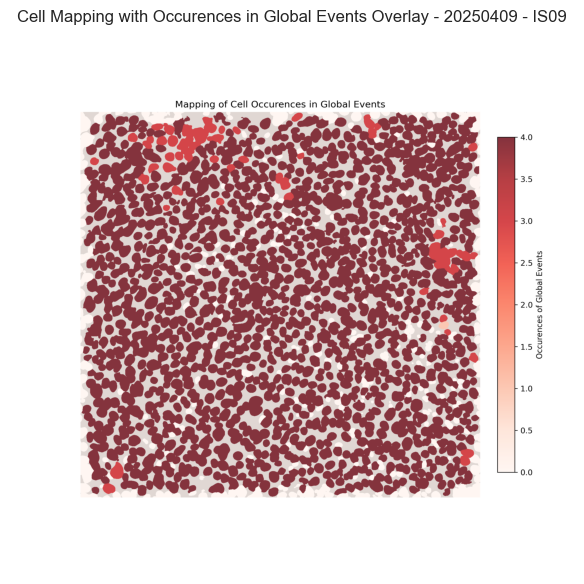

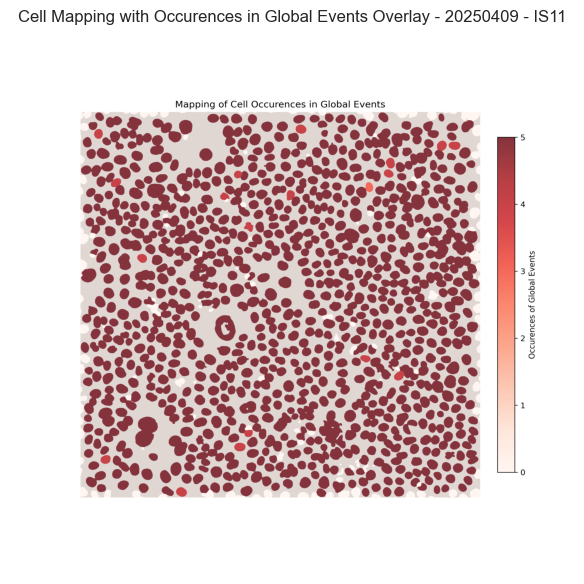

In [6]:
for (date, image_sequence), df_subset in global_events.groupby(["date", "image_sequence"]):
    visualize_image(
        image_source={f"{date} - {image_sequence}": f"D:/Mateo/{date}/Output/{image_sequence}"},
        image_name="cell-mapping/cell_occurences_in_global_events_overlay.png",
        title="Cell Mapping with Occurences in Global Events Overlay",
        figsize=(6, 6)
    )

### Cells occurences in different events

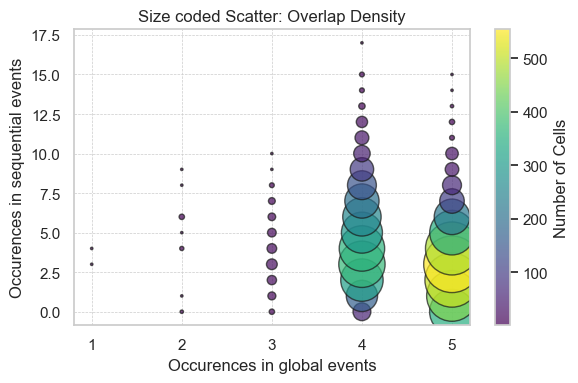

In [7]:
plot_scatter_size_coded(
    df=control_cells,
    x_col="Occurences in global events",
    y_col="Occurences in sequential events",
    size_scale=3
)

## SEQUENTIAL EVENTS ANALYSIS

In [8]:
sequential_events = control_events[control_events["Event type"] == "SequentialEvent"].copy()

### Cell-cell communcation & nucleus distances

[2025-08-11 16:06:27] [INFO] calcium: plot_histogram: removed 3 outliers out of 4293 on 'Distance (um)' (lower=-5.5, upper=36.15)


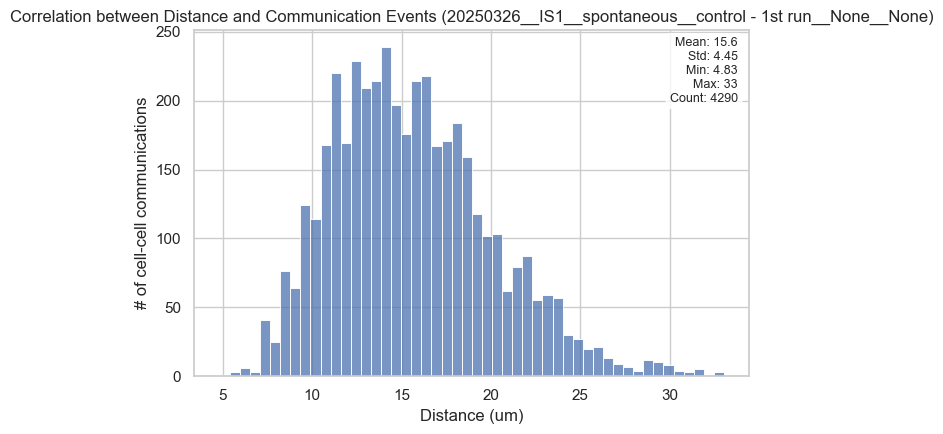

[2025-08-11 16:06:27] [INFO] calcium: plot_histogram: removed 2 outliers out of 5557 on 'Distance (um)' (lower=-4.93, upper=36.86)


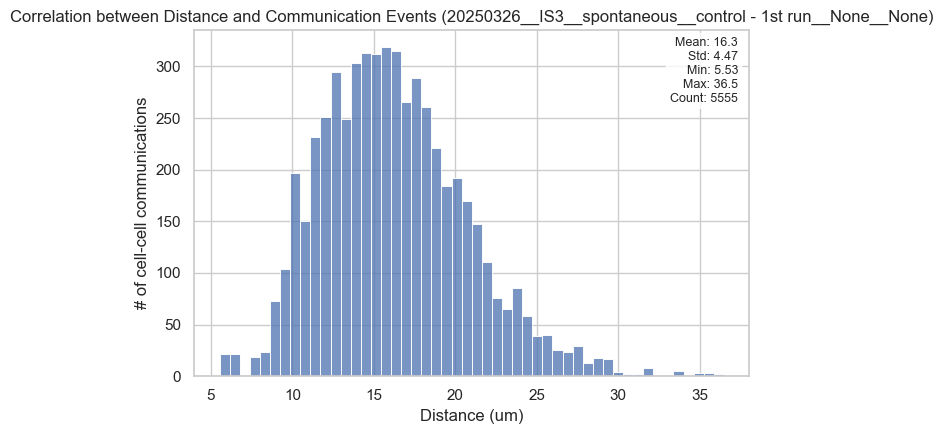

[2025-08-11 16:06:27] [INFO] calcium: plot_histogram: removed 0 outliers out of 3206 on 'Distance (um)' (lower=-5.18, upper=33.74)


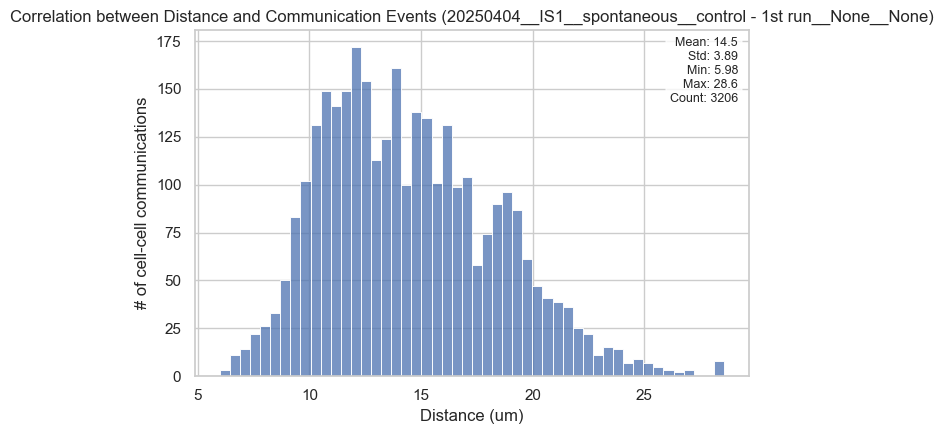

[2025-08-11 16:06:27] [INFO] calcium: plot_histogram: removed 2 outliers out of 3192 on 'Distance (um)' (lower=-5.59, upper=33.33)


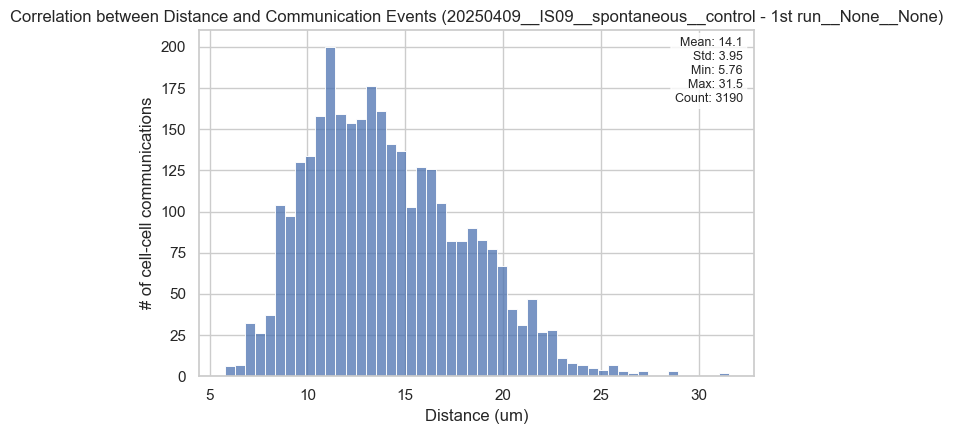

[2025-08-11 16:06:27] [INFO] calcium: plot_histogram: removed 1 outliers out of 931 on 'Distance (um)' (lower=-7.04, upper=38.25)


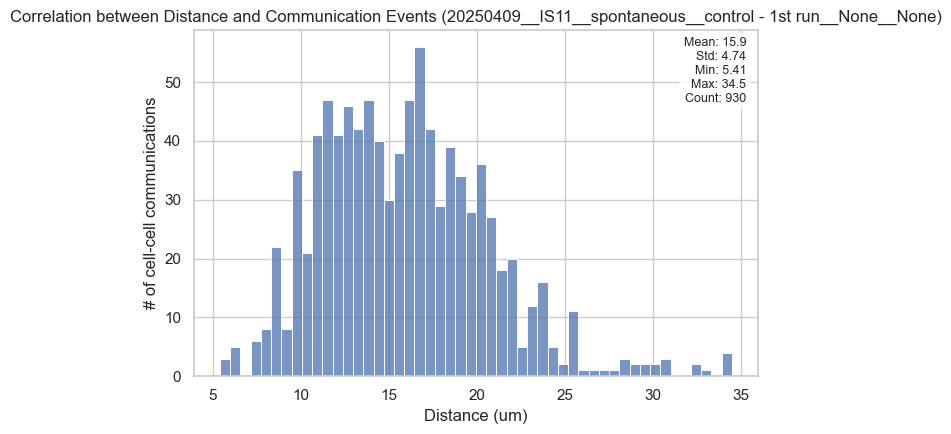

[2025-08-11 16:06:27] [INFO] calcium: plot_histogram: removed 8 outliers out of 17179 on 'Distance (um)' (lower=-7.04, upper=38.25)


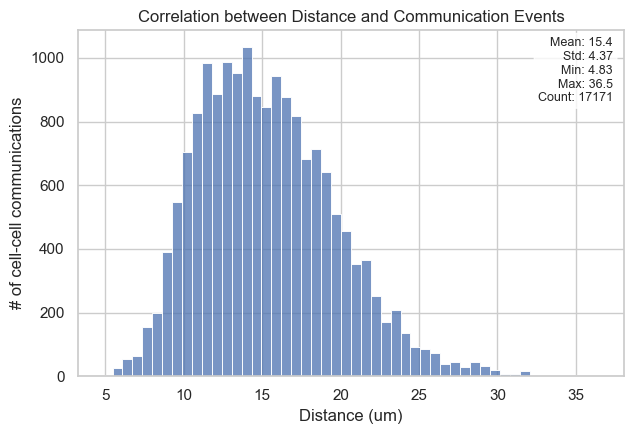

In [9]:
for dataset_name, df_subset in control_communications.groupby("dataset"):
    plot_histogram(
        df=df_subset,
        column="Distance (um)",
        title=f"Correlation between Distance and Communication Events ({dataset_name})",
        ylabel="# of cell-cell communications",
        bin_count=50,
        filter_outliers=True,
        outliers_bounds=(3,3)
    )

plot_histogram(
    df=control_communications,
    column="Distance (um)",
    title="Correlation between Distance and Communication Events",
    ylabel="# of cell-cell communications",
    bin_count=50,
    filter_outliers=True,
    outliers_bounds=(3,3),
    outliers_bygroup="dataset"
)

### Mapping of cell occurences in sequential events

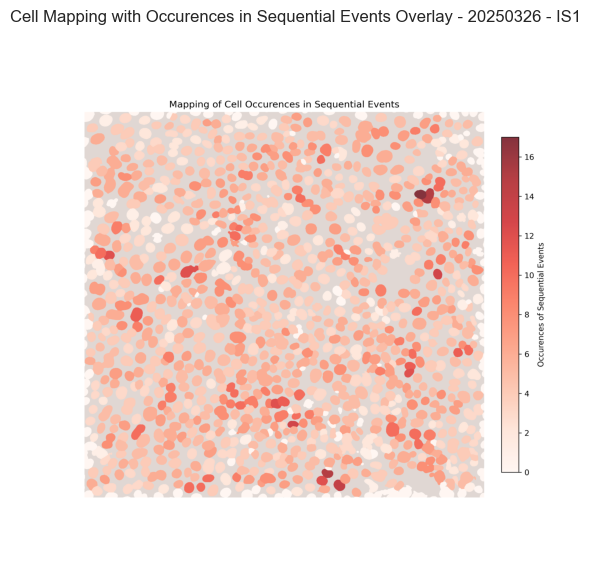

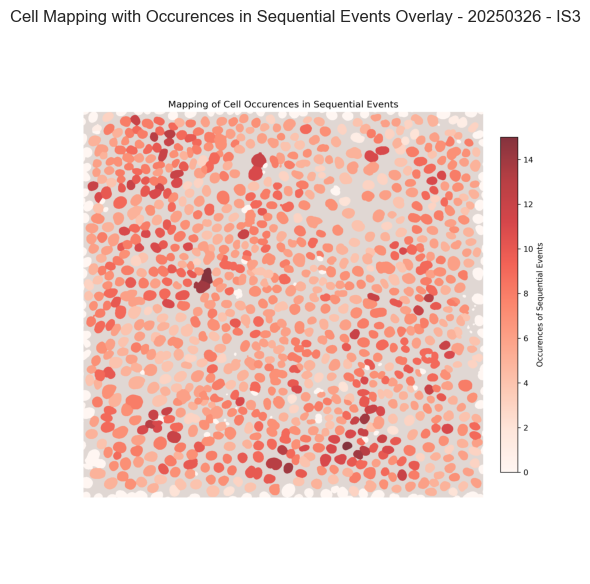

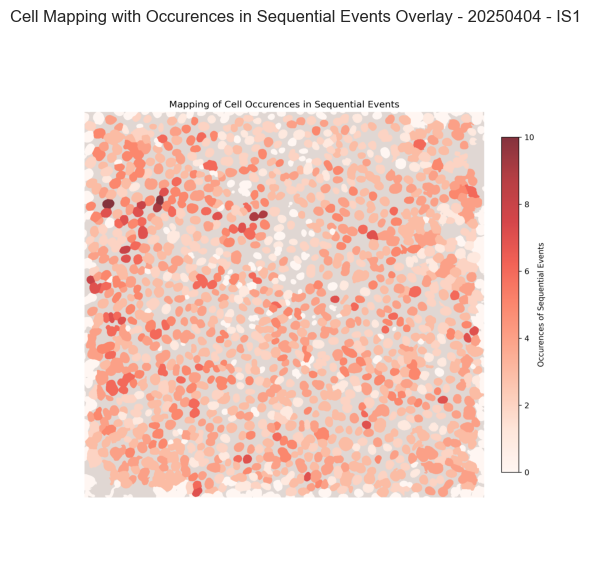

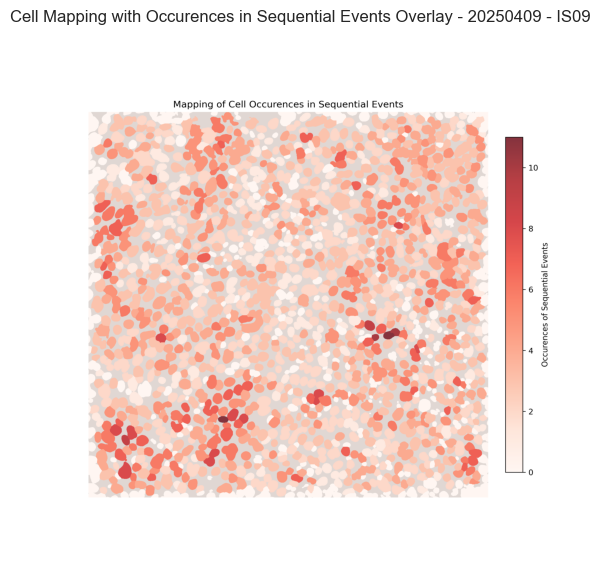

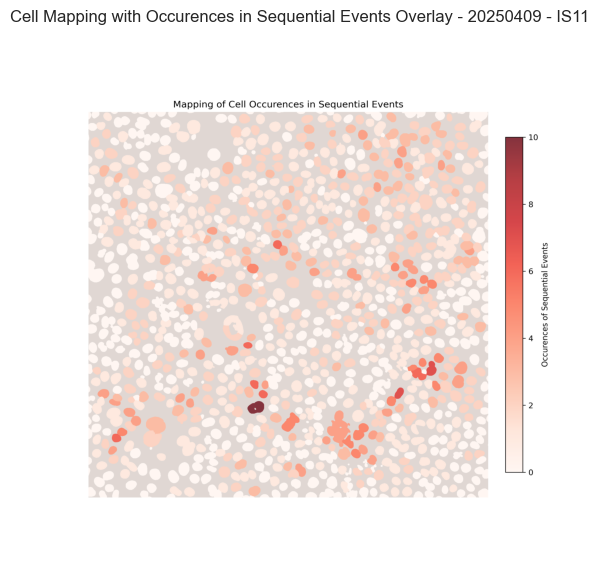

In [10]:
for (date, image_sequence), df_subset in sequential_events.groupby(["date", "image_sequence"]):
    visualize_image(
        image_source={f"{date} - {image_sequence}": f"D:/Mateo/{date}/Output/{image_sequence}"},
        image_name="cell-mapping/cell_occurences_in_sequential_events_overlay.png",
        title="Cell Mapping with Occurences in Sequential Events Overlay",
        figsize=(6, 6)
    )

### Peak features repeatability

[2025-08-11 16:06:32] [INFO] calcium: plot_violin: removed 372 outliers out of 21797 on 'Duration (s)' (lower=-36, upper=90)


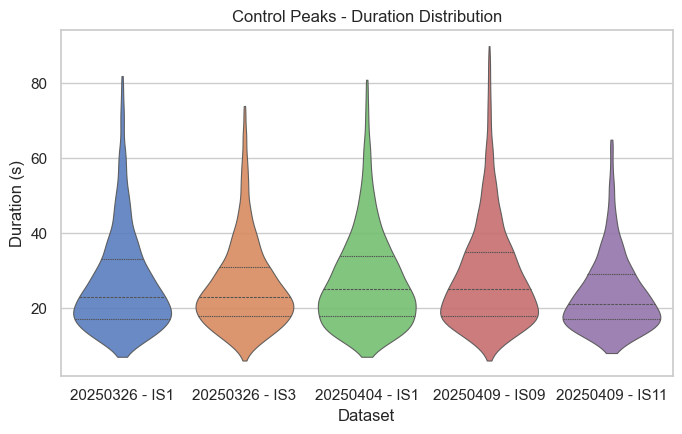

[2025-08-11 16:06:32] [INFO] calcium: plot_violin: removed 649 outliers out of 21797 on 'Prominence (noise std units)' (lower=-243.3, upper=393.18)


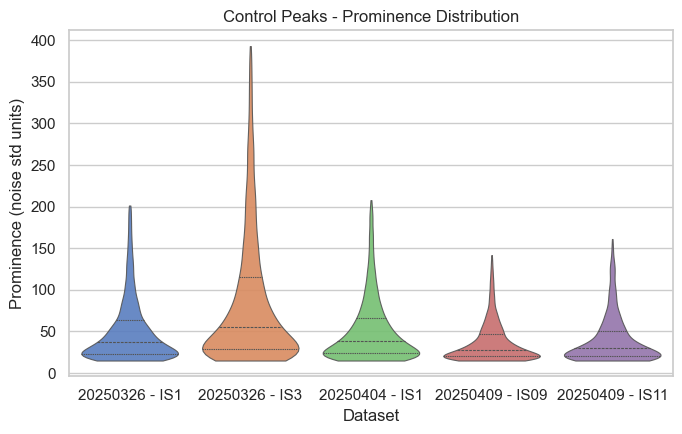

In [11]:
control_peaks["dataset name"] = control_peaks['date'].astype(str) + " - " + control_peaks['image_sequence'].astype(str)

mapping_events_to_peaks = control_events.loc[control_events["Event type"] == "SequentialEvent", ["Event ID", "dataset"]]
subset_peaks_sequential_events = control_peaks.merge(mapping_events_to_peaks, 
                                                     on=["Event ID", "dataset"], 
                                                     how="inner", 
                                                     validate="m:1")

plot_violin(
    df=subset_peaks_sequential_events,
    x="dataset name",
    y="Duration (s)",
    title="Control Peaks - Duration Distribution",
    ylabel="Duration (s)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)
plot_violin(
    df=subset_peaks_sequential_events,
    x="dataset name",
    y="Prominence (noise std units)",
    title="Control Peaks - Prominence Distribution",
    ylabel="Prominence (noise std units)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)

[2025-08-11 16:06:33] [INFO] calcium: plot_violin: removed 1 outliers out of 17179 on 'Speed (um/s)' (lower=-23.375, upper=36.3)


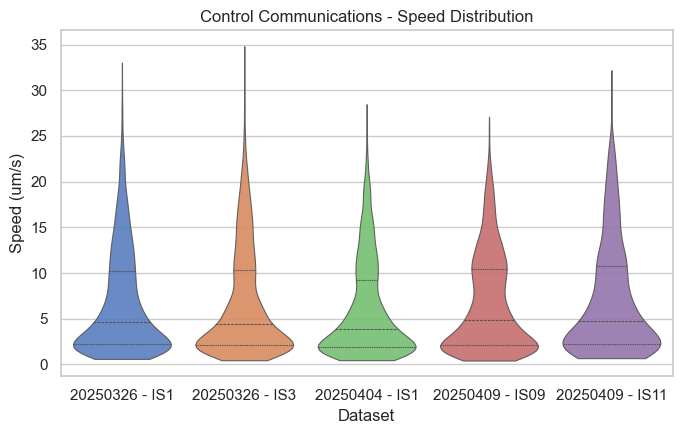

In [12]:
control_communications["dataset name"] = control_communications['date'].astype(str) + " - " + control_communications['image_sequence'].astype(str)

plot_violin(
    df=control_communications,
    x="dataset name",
    y="Speed (um/s)",
    title="Control Communications - Speed Distribution",
    ylabel="Speed (um/s)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)

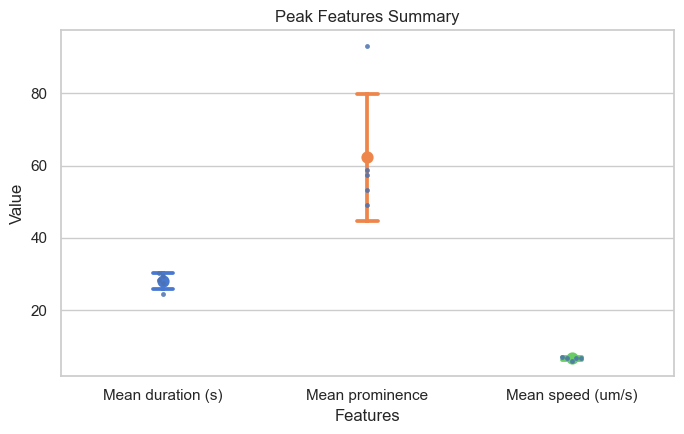

In [13]:
peak_features_summary_list = []

for dataset_name, df_subset in subset_peaks_sequential_events.groupby("dataset name"):
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean duration (s)",
        "Value": df_subset["Duration (s)"].mean()
    })
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean prominence",
        "Value": df_subset["Prominence (noise std units)"].mean()
    })

for dataset_name, df_subset in control_communications.groupby("dataset name"):
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean speed (um/s)",
        "Value": df_subset["Speed (um/s)"].mean()
    })

peak_features_summary_df = pd.DataFrame(peak_features_summary_list)

plot_points_mean_std(
    df=peak_features_summary_df,
    x="Value type",
    y="Value",
    title="Peak Features Summary",
    ylabel="Value",
    xlabel="Features"
)

## INDIVIDUAL EVENTS

In [16]:
individual_peaks = control_peaks[control_peaks["In event"] == "individual"].copy()

### Mapping of cell occurences in individual events

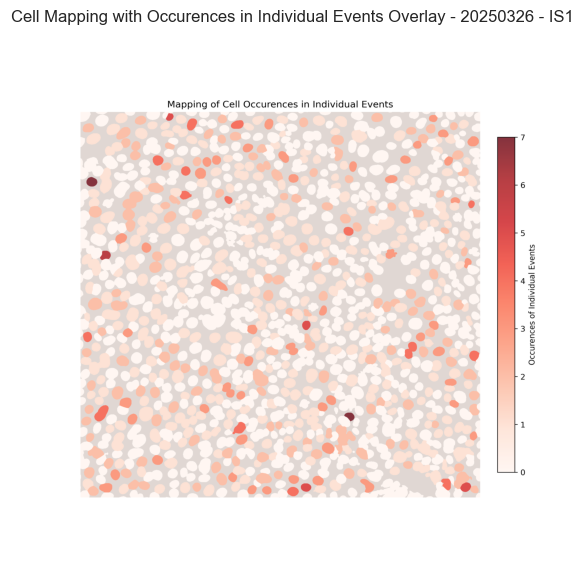

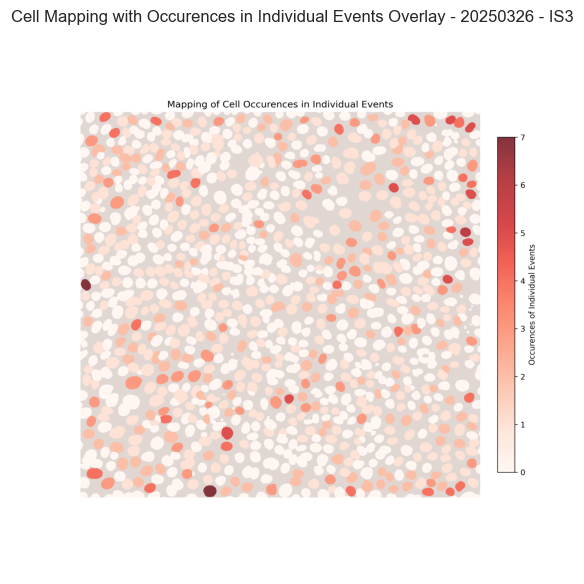

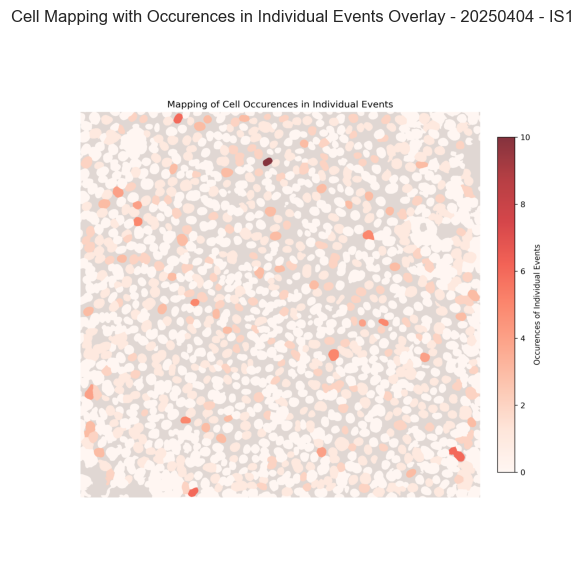

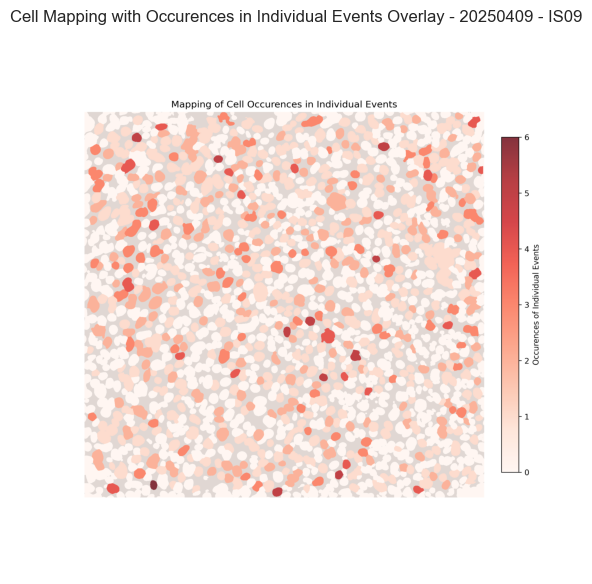

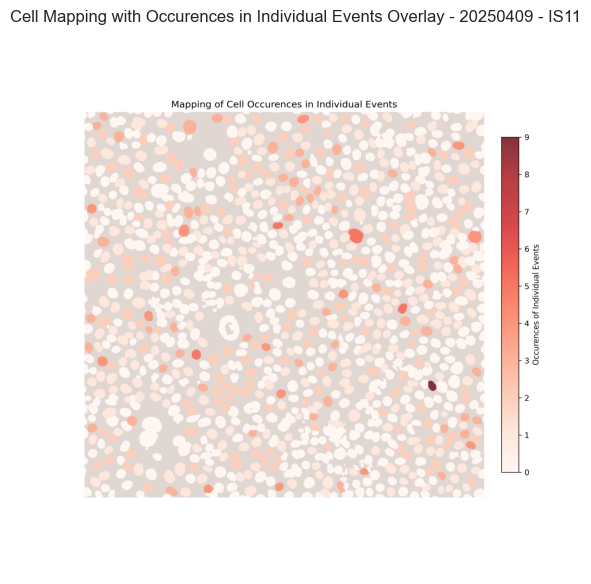

In [17]:

for (date, image_sequence), df_subset in individual_peaks.groupby(["date", "image_sequence"]):
    visualize_image(
        image_source={f"{date} - {image_sequence}": f"D:/Mateo/{date}/Output/{image_sequence}"},
        image_name="cell-mapping/cell_occurences_in_individual_events_overlay.png",
        title="Cell Mapping with Occurences in Individual Events Overlay",
        figsize=(6, 6)
    )

### Peak features repeatability

[2025-08-11 16:46:02] [INFO] calcium: plot_violin: removed 86 outliers out of 4614 on 'Duration (s)' (lower=-37, upper=89)


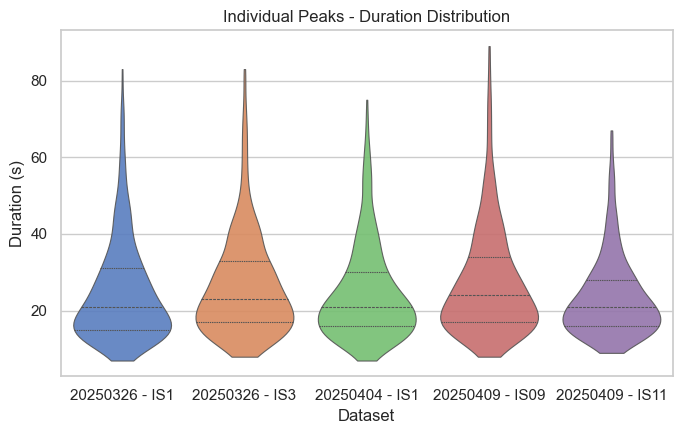

[2025-08-11 16:46:02] [INFO] calcium: plot_violin: removed 217 outliers out of 4614 on 'Prominence (noise std units)' (lower=-131.92, upper=222.62)


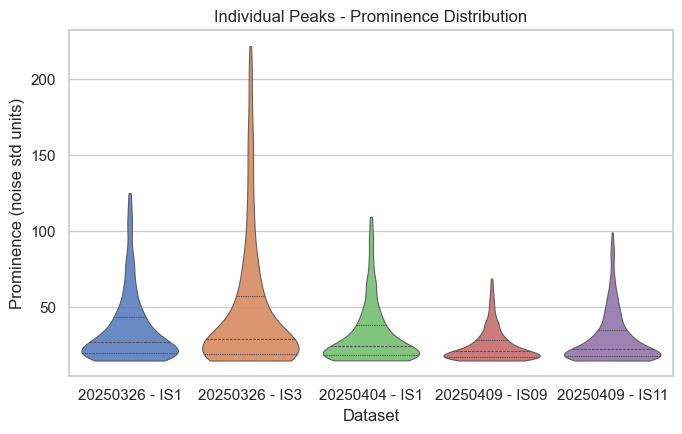

In [19]:
control_peaks["dataset name"] = control_peaks['date'].astype(str) + " - " + control_peaks['image_sequence'].astype(str)

plot_violin(
    df=individual_peaks,
    x="dataset name",
    y="Duration (s)",
    title="Individual Peaks - Duration Distribution",
    ylabel="Duration (s)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)
plot_violin(
    df=individual_peaks,
    x="dataset name",
    y="Prominence (noise std units)",
    title="Individual Peaks - Prominence Distribution",
    ylabel="Prominence (noise std units)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)

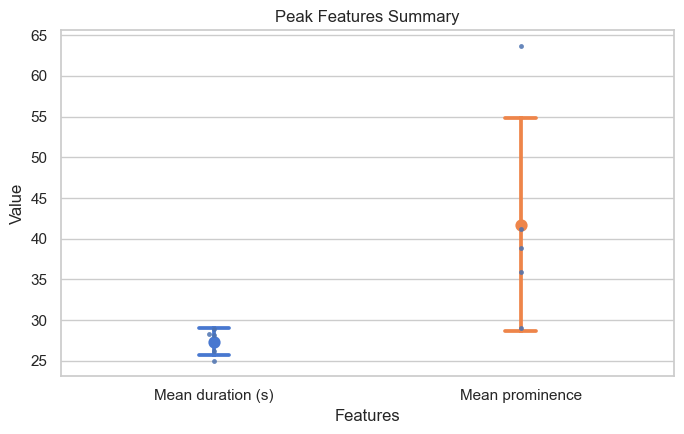

In [18]:
peak_features_summary_list = []

for dataset_name, df_subset in individual_peaks.groupby("dataset name"):
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean duration (s)",
        "Value": df_subset["Duration (s)"].mean()
    })
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean prominence",
        "Value": df_subset["Prominence (noise std units)"].mean()
    })

peak_features_summary_df = pd.DataFrame(peak_features_summary_list)

plot_points_mean_std(
    df=peak_features_summary_df,
    x="Value type",
    y="Value",
    title="Peak Features Summary",
    ylabel="Value",
    xlabel="Features"
)